#### [フロアプランの壁の隙間を埋める作業]
- y軸方向に移動させたものを出力
- x軸方向に移動させたものを出力
- 単一ファイルに関しての処理可能
- 4つのステージに分けて描画

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.ops import polygonize
from collections import defaultdict
import copy

In [2]:
# 部屋の種類と対応する数値ラベルの定義
ROOM_CLASS = {
    "living_room": 1,
    "kitchen": 2,
    "bedroom": 3,
    "bathroom": 4,
    "balcony": 5,
    "entrance": 6,
    "dining room": 7,
    "study room": 8,
    "storage": 10,
    "front door": 15,
    "unknown": 16,
    "interior_door": 17
}

In [3]:
# 数値ラベルから部屋の名前への逆引き辞書
ROOM_CLASS_INV = {v: k for k, v in ROOM_CLASS.items()}

# フロアプランデータをJSONファイルから読み込む
file_path = '../rplan_json/floorplan_dataset/20006.json'  # JSONファイルのパスを指定
try:
    with open(file_path, 'r') as f:
        data = json.load(f)  # JSONファイルを読み込み、Pythonの辞書に変換
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit(1)
except json.JSONDecodeError:
    print("Error: Failed to decode JSON.")
    exit(1)

In [4]:
# 部屋の種類、ボックス、エッジ、エッジと部屋の対応
room_type = data.get("room_type", [])
boxes = data.get("boxes", [])
edges = data.get("edges", [])
ed_rm = data.get("ed_rm", [])

# 元の edges をコピーして保持
original_edges = copy.deepcopy(edges)

# 部屋の種類ごとに色を割り当て
colors = list(mcolors.TABLEAU_COLORS.values())
room_type_set = set(room_type)
room_colors = {}
for i, rt in enumerate(sorted(room_type_set)):
    room_colors[rt] = colors[i % len(colors)]

In [5]:
# 水平方向の処理
# 1. ドアではないエッジを抽出（edge[4] が 15 または 17 でないもの）
non_door_edge_indices = []
for idx, edge in enumerate(edges):
    if edge[4] not in [15, 17]:
        non_door_edge_indices.append(idx)

# 2. 抽出したエッジを水平方向と鉛直方向に分ける
horizontal_edges = []
vertical_edges = []
for idx in non_door_edge_indices:
    edge = edges[idx]
    x1, y1, x2, y2, room_type1, room_type2 = edge
    if abs(y1 - y2) < 1e-6:
        # 水平方向のエッジ
        horizontal_edges.append({'idx': idx, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    elif abs(x1 - x2) < 1e-6:
        # 鉛直方向のエッジ
        vertical_edges.append({'idx': idx, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

# 3. エッジ間の接続情報を構築（更新前の状態）
# ドアのエッジは除外
point_to_edges_pre_update = defaultdict(set)
for idx, edge in enumerate(edges):
    room_type1 = edge[4]
    if room_type1 in [15, 17]:
        continue  # ドアのエッジは除外
    x1, y1, x2, y2 = edge[0], edge[1], edge[2], edge[3]
    point_to_edges_pre_update[(x1, y1)].add(idx)
    point_to_edges_pre_update[(x2, y2)].add(idx)

# 4. Union-Find データ構造を初期化
parent = {}
for edge in horizontal_edges:
    idx = edge['idx']
    parent[idx] = idx

def find(u):
    while parent[u] != u:
        parent[u] = parent[parent[u]]  # パス圧縮
        u = parent[u]
    return u

def union(u, v):
    pu = find(u)
    pv = find(v)
    if pu != pv:
        parent[pu] = pv

# 5. エッジを y 座標でソートして効率的に比較
horizontal_edges.sort(key=lambda e: e['y1'])

n_edges = len(horizontal_edges)

for i in range(n_edges):
    edge_a = horizontal_edges[i]
    idx_a = edge_a['idx']
    x_range_a = sorted([edge_a['x1'], edge_a['x2']])
    y_a = edge_a['y1']
    for j in range(i + 1, n_edges):
        edge_b = horizontal_edges[j]
        idx_b = edge_b['idx']
        y_b = edge_b['y1']
        if y_b - y_a > 6:
            break  # y 座標の差が 4 を超える場合、以降のエッジは比較不要
        x_range_b = sorted([edge_b['x1'], edge_b['x2']])
        # x 座標の範囲が少しでも重なっているか確認
        if x_range_a[1] >= x_range_b[0] and x_range_b[1] >= x_range_a[0]:
            union(idx_a, idx_b)

# 6. 各グループの最小の y 座標でエッジを更新
groups = defaultdict(list)
for edge in horizontal_edges:
    idx = edge['idx']
    leader = find(idx)
    groups[leader].append(edge)

# 更新されたエッジのインデックスを保持
updated_edge_indices = set()

# 更新前のエッジの y 座標を保持
edge_y_pre_update = {}
for edge in horizontal_edges:
    idx = edge['idx']
    edge_y_pre_update[idx] = edge['y1']

for group in groups.values():
    y_min = min(edge['y1'] for edge in group)
    for edge in group:
        idx_edge = edge['idx']
        # edges リストの該当するエッジを更新
        if edges[idx_edge][1] != y_min:
            edges[idx_edge][1] = y_min
            edges[idx_edge][3] = y_min
            # horizontal_edges リストも更新
            edge['y1'] = y_min
            edge['y2'] = y_min
            updated_edge_indices.add(idx_edge)

# 7. 更新されたエッジが更新される前に接続していたエッジの座標を更新
for idx in updated_edge_indices:
    # 更新前の y 座標を取得
    y_pre = edge_y_pre_update[idx]
    edge = edges[idx]
    y_new = edge[1]  # 更新後の y 座標
    x1, _, x2, _, _, _ = edge
    points = [(x1, y_pre), (x2, y_pre)]
    for x, y in points:
        connected_edges = point_to_edges_pre_update.get((x, y), set())
        for conn_idx in connected_edges:
            if conn_idx == idx:
                continue
            conn_edge = edges[conn_idx]
            conn_room_type1 = conn_edge[4]
            if conn_room_type1 in [15, 17]:
                continue  # ドアのエッジは変更しない
            # 始点または終点が接続していた場合、y 座標を更新
            if (conn_edge[0], conn_edge[1]) == (x, y_pre):
                conn_edge[1] = y_new
            if (conn_edge[2], conn_edge[3]) == (x, y_pre):
                conn_edge[3] = y_new

In [6]:
# ステージ2: 水平方向の変更後の edges
edges_stage2 = copy.deepcopy(edges)

# ここから鉛直方向の処理を追加します

# 1. ドアではないエッジを再度抽出（更新された edges を使用）
non_door_edge_indices = []
for idx, edge in enumerate(edges):
    if edge[4] not in [15, 17]:
        non_door_edge_indices.append(idx)

# 2. 抽出したエッジを水平方向と鉛直方向に分ける
horizontal_edges = []
vertical_edges = []
for idx in non_door_edge_indices:
    edge = edges[idx]
    x1, y1, x2, y2, room_type1, room_type2 = edge
    if abs(y1 - y2) < 1e-6:
        # 水平方向のエッジ
        horizontal_edges.append({'idx': idx, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    elif abs(x1 - x2) < 1e-6:
        # 鉛直方向のエッジ
        vertical_edges.append({'idx': idx, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

# 3. エッジ間の接続情報を再構築（更新前の状態）
# ドアのエッジは除外
point_to_edges_pre_update = defaultdict(set)
for idx, edge in enumerate(edges):
    room_type1 = edge[4]
    if room_type1 in [15, 17]:
        continue  # ドアのエッジは除外
    x1, y1, x2, y2 = edge[0], edge[1], edge[2], edge[3]
    point_to_edges_pre_update[(x1, y1)].add(idx)
    point_to_edges_pre_update[(x2, y2)].add(idx)

# 4. Union-Find データ構造を初期化
parent = {}
for edge in vertical_edges:
    idx = edge['idx']
    parent[idx] = idx

def find(u):
    while parent[u] != u:
        parent[u] = parent[parent[u]]  # パス圧縮
        u = parent[u]
    return u

def union(u, v):
    pu = find(u)
    pv = find(v)
    if pu != pv:
        parent[pu] = pv

# 5. エッジを x 座標でソートして効率的に比較
vertical_edges.sort(key=lambda e: e['x1'])

n_edges = len(vertical_edges)

for i in range(n_edges):
    edge_a = vertical_edges[i]
    idx_a = edge_a['idx']
    y_range_a = sorted([edge_a['y1'], edge_a['y2']])
    x_a = edge_a['x1']
    for j in range(i + 1, n_edges):
        edge_b = vertical_edges[j]
        idx_b = edge_b['idx']
        x_b = edge_b['x1']
        if x_b - x_a > 6:
            break  # x 座標の差が 4 を超える場合、以降のエッジは比較不要
        y_range_b = sorted([edge_b['y1'], edge_b['y2']])
        # y 座標の範囲が少しでも重なっているか確認
        if y_range_a[1] >= y_range_b[0] and y_range_b[1] >= y_range_a[0]:
            union(idx_a, idx_b)

# 6. 各グループの最小の x 座標でエッジを更新
groups = defaultdict(list)
for edge in vertical_edges:
    idx = edge['idx']
    leader = find(idx)
    groups[leader].append(edge)

# 更新されたエッジのインデックスを保持
updated_edge_indices = set()

# 更新前のエッジの x 座標を保持
edge_x_pre_update = {}
for edge in vertical_edges:
    idx = edge['idx']
    edge_x_pre_update[idx] = edge['x1']

for group in groups.values():
    x_min = min(edge['x1'] for edge in group)
    for edge in group:
        idx_edge = edge['idx']
        # edges リストの該当するエッジを更新
        if edges[idx_edge][0] != x_min:
            edges[idx_edge][0] = x_min
            edges[idx_edge][2] = x_min
            # vertical_edges リストも更新
            edge['x1'] = x_min
            edge['x2'] = x_min
            updated_edge_indices.add(idx_edge)

# 7. 更新されたエッジが更新される前に接続していたエッジの座標を更新
for idx in updated_edge_indices:
    # 更新前の x 座標を取得
    x_pre = edge_x_pre_update[idx]
    edge = edges[idx]
    x_new = edge[0]  # 更新後の x 座標
    _, y1, _, y2, _, _ = edge
    points = [(x_pre, y1), (x_pre, y2)]
    for x, y in points:
        connected_edges = point_to_edges_pre_update.get((x, y), set())
        for conn_idx in connected_edges:
            if conn_idx == idx:
                continue
            conn_edge = edges[conn_idx]
            conn_room_type1 = conn_edge[4]
            if conn_room_type1 in [15, 17]:
                continue  # ドアのエッジは変更しない
            # 始点または終点が接続していた場合、x 座標を更新
            if (conn_edge[0], conn_edge[1]) == (x_pre, y):
                conn_edge[0] = x_new
            if (conn_edge[2], conn_edge[3]) == (x_pre, y):
                conn_edge[2] = x_new

# ステージ3: 鉛直方向の変更後の edges
edges_stage3 = copy.deepcopy(edges)

In [7]:
# ドアの処理を追加

from shapely.geometry import LineString, Polygon, MultiLineString
from shapely.ops import polygonize, unary_union

# 1. ドアのエッジを抽出（edge[5] が 15 または 17 のもの）
door_edges = [edge for edge in edges if edge[4] in [15, 17]]

# ドア以外のエッジを取得
non_door_edges = [edge for edge in edges if edge[4] not in [15, 17]]

# 1. ドアのエッジから閉じたポリゴンを生成
door_line_strings = [LineString([(edge[0], edge[1]), (edge[2], edge[3])]) for edge in door_edges]
door_multilines = unary_union(door_line_strings)
door_polygons = list(polygonize(door_multilines))

# 新たに描画するドアの長辺を保持するリスト
new_door_edges = []

# ドアポリゴンごとに処理を行う
for door_polygon in door_polygons:
    # ドアのバウンディングボックスから幅と高さを取得
    minx, miny, maxx, maxy = door_polygon.bounds
    width = maxx - minx
    height = maxy - miny

    # ドアが水平方向か鉛直方向かを判定
    if width >= height:
        orientation = 'horizontal'
    else:
        orientation = 'vertical'

    # ポリゴンの外周の座標を取得
    coords = list(door_polygon.exterior.coords)

    # そのポリゴンのエッジを取得
    edges_in_polygon = []
    for i in range(len(coords) - 1):  # 最後の点は始点と同じなので除外
        p1 = coords[i]
        p2 = coords[i + 1]
        length = LineString([p1, p2]).length
        if abs(p1[0] - p2[0]) < 1e-6:
            edge_orientation = 'vertical'
        elif abs(p1[1] - p2[1]) < 1e-6:
            edge_orientation = 'horizontal'
        else:
            continue  # 対角線などは無視
        edges_in_polygon.append({'p1': p1, 'p2': p2, 'length': length, 'orientation': edge_orientation})

    # 2-1. 長辺のうち小さい座標を持つ辺を取得
    if orientation == 'horizontal':
        # 水平方向のドアの場合
        # 水平方向のエッジのうち長さが最大のものを選択
        horizontal_edges = [e for e in edges_in_polygon if e['orientation'] == 'horizontal']
        # print('horizon:', horizontal_edges)
        if not horizontal_edges:
            continue  # 水平方向のエッジがない場合はスキップ
        max_length = max(e['length'] for e in horizontal_edges)
        # print("max_length:", max_length)
        long_edges = [e for e in horizontal_edges if abs(e['length'] - max_length) < 1e-6]
        # print("long_edges:", long_edges)
        # y座標が小さい方のエッジを選択
        selected_edge = min(long_edges, key=lambda e: min(e['p1'][1], e['p2'][1]))
        # print("selected_edge:", selected_edge)
    else:
        # 鉛直方向のドアの場合
        # 鉛直方向のエッジのうち長さが最大のものを選択
        vertical_edges = [e for e in edges_in_polygon if e['orientation'] == 'vertical']
        if not vertical_edges:
            continue  # 鉛直方向のエッジがない場合はスキップ
        max_length = max(e['length'] for e in vertical_edges)
        long_edges = [e for e in vertical_edges if abs(e['length'] - max_length) < 1e-6]
        # x座標が小さい方のエッジを選択
        selected_edge = min(long_edges, key=lambda e: min(e['p1'][0], e['p2'][0]))

    # 2-2. ドア以外のエッジから条件に合致するエッジを探し、座標を調整
    if orientation == 'horizontal':
        # 水平方向のドアの場合
        door_x_range = sorted([selected_edge['p1'][0], selected_edge['p2'][0]])
        door_y = selected_edge['p1'][1]  # y座標は同じ

        # x座標の範囲が重なる非ドアエッジを探す
        candidate_edges = []
        for edge in non_door_edges:
            x1, y1, x2, y2, _, _ = edge
            if abs(y1 - y2) < 1e-6:
                # 水平方向のエッジは無視
                # continue
                edge_x_range = sorted([x1, x2])
                if door_x_range[1] >= edge_x_range[0] and edge_x_range[1] >= door_x_range[0]:
                    # y方向の距離を計算
                    distance = abs(door_y - y1)
                    candidate_edges.append({'edge': edge, 'distance': distance, 'y': y1})

        if candidate_edges:
            # 最も近いエッジを選択
            candidate_edges.sort(key=lambda e: e['distance'])
            closest_edge = candidate_edges[0]
            adjusted_y = closest_edge['y']
            # y座標を調整
            door_y = adjusted_y

        # 新たなドアのエッジを保存
        new_door_edges.append({'p1': (door_x_range[0], door_y), 'p2': (door_x_range[1], door_y)})

    else:
        # 鉛直方向のドアの場合
        door_y_range = sorted([selected_edge['p1'][1], selected_edge['p2'][1]])
        door_x = selected_edge['p1'][0]  # x座標は同じ

        # y座標の範囲が重なる非ドアエッジを探す
        candidate_edges = []
        for edge in non_door_edges:
            x1, y1, x2, y2, _, _ = edge
            if abs(x1 - x2) < 1e-6:
                # 鉛直方向のエッジは無視
                # continue
                edge_y_range = sorted([y1, y2])
                if door_y_range[1] >= edge_y_range[0] and edge_y_range[1] >= door_y_range[0]:
                    # x方向の距離を計算
                    distance = abs(door_x - x1)
                    candidate_edges.append({'edge': edge, 'distance': distance, 'x': x1})

        if candidate_edges:
            # 最も近いエッジを選択
            candidate_edges.sort(key=lambda e: e['distance'])
            closest_edge = candidate_edges[0]
            adjusted_x = closest_edge['x']
            # x座標を調整
            door_x = adjusted_x

        # 新たなドアのエッジを保存
        new_door_edges.append({'p1': (door_x, door_y_range[0]), 'p2': (door_x, door_y_range[1])})

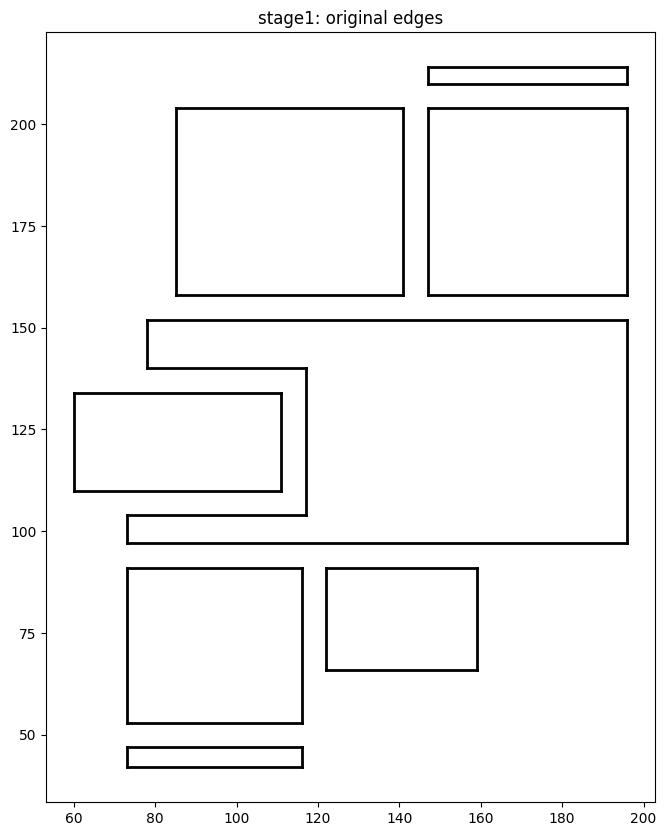

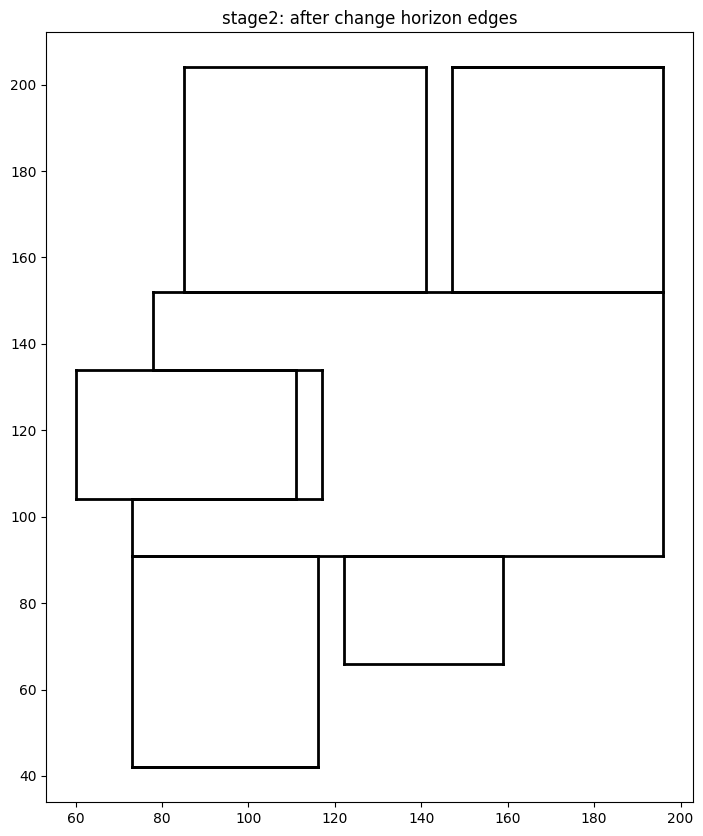

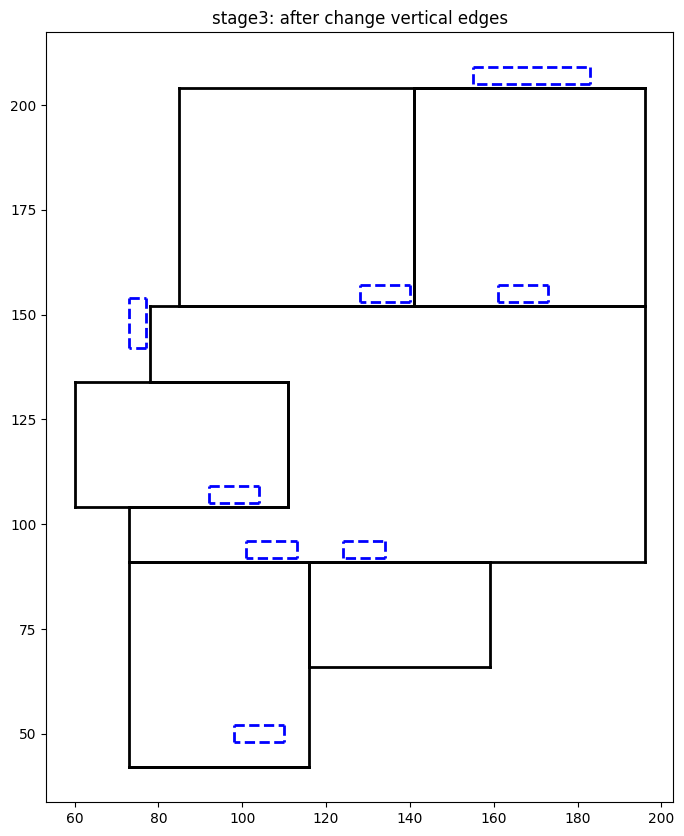

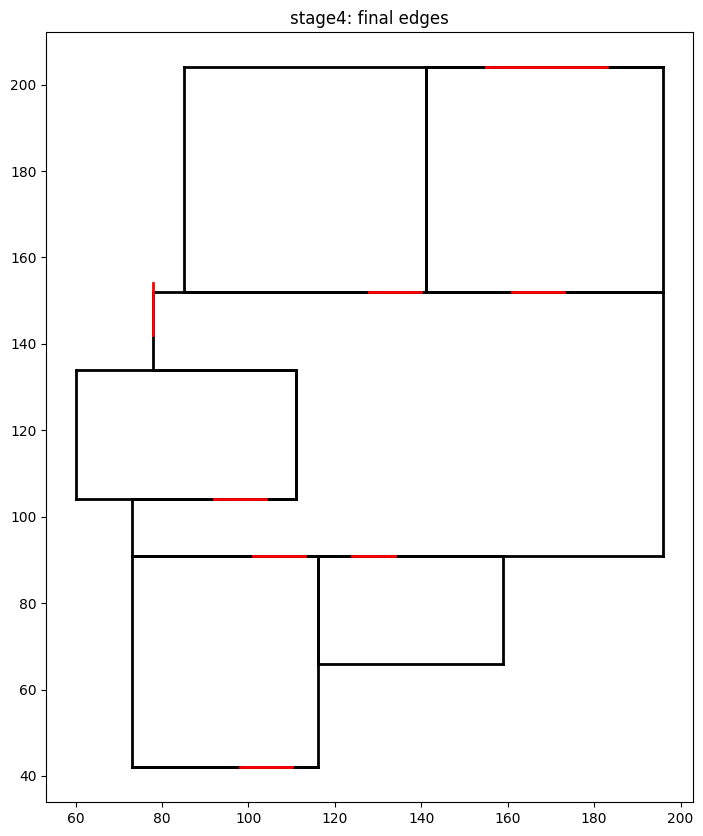

In [8]:
# ステージ4: ドアの変更後の edges
edges_stage4 = copy.deepcopy(edges)

# --- 指定された処理の追加ここまで ---

# --- 追加部分: 元のドアエッジを抽出 ---
# 元のドアエッジを抽出し、描画用に整形
original_door_edges_formatted = []
for edge in door_edges:
    x1, y1, x2, y2, _, _ = edge
    original_door_edges_formatted.append({'p1': (x1, y1), 'p2': (x2, y2)})

# ステージごとのエッジを出力または描画
def plot_edges(edges_list, title, new_door_edges=None, original_door_edges=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    # 非ドアエッジを描画
    for edge in edges_list:
        if len(edge) < 6:
            continue
        x1, y1, x2, y2, room_type1, room_type2 = edge
        if room_type1 in [15, 17] or room_type2 in [15, 17]:
            # ドアのエッジは描画しない
            continue
        color = 'black'
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)
    # 新たなドアのエッジを描画
    if new_door_edges:
        for edge in new_door_edges:
            x1, y1 = edge['p1']
            x2, y2 = edge['p2']
            ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)
    # 元のドアのエッジを描画
    if original_door_edges:
        for edge in original_door_edges:
            x1, y1 = edge['p1']
            x2, y2 = edge['p2']
            ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2, linestyle='--')
    ax.set_aspect('equal', adjustable='box')
    ax.axis('on')
    plt.show()

# ステージ1のエッジを描画
plot_edges(original_edges, 'stage1: original edges')

# ステージ2のエッジを描画
plot_edges(edges_stage2, 'stage2: after change horizon edges')

# ステージ3のエッジを描画
plot_edges(edges_stage3, 'stage3: after change vertical edges', original_door_edges=original_door_edges_formatted)

# ステージ4のエッジを描画
plot_edges(edges_stage4, 'stage4: final edges', new_door_edges=new_door_edges)